# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
Цель этого проекта - использовать методы моделирования для анализа набора данных о качестве вин. Набор данных относится к красному и белому вариантам португальского вина "Винью Верде". Из-за проблем с конфиденциальностью и логистики доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. Д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин едят больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут использоваться для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, все ли входные переменные актуальны. Так что было бы интересно протестировать методы выбора функций.


[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [32]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [23]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = wine.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [15]:
wine = pd.read_csv("winequalityN.csv")

print('Data type: ', type(wine))
print('Datasets:', 'wine:', wine.shape)

Data type:  <class 'pandas.core.frame.DataFrame'>
Datasets: wine: (6497, 13)


## 2.4 Статистика и визуализации

In [16]:
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

  - type: 
  - Fixed acidity
  - Volatile acidity
  - Citric acid
  - Residual sugar
  - Chlorides
  - Free sulfur dioxide
  - Total sulfur dioxide
  - Density
  - pH
  - Sulfates
  - Alcohol
  
  Описание переменных:\ Входные переменные (на основе физико-химических тестов):\ 1 - фиксированная кислотность\ 2 - летучая кислотность\ 3 - лимонная кислота\ 4 - остаточный сахар\ 5 - хлориды\ 6 - свободный диоксид серы\ 7 - общий диоксид серы\ 8 - плотность\ 9 - pH\ 10 - сульфаты\ 11 - спирт
  
  Выходная переменная (на основе сенсорных данных):\ 12 - качество (оценка от 0 до 10)




### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

Интересным наблюдением может быть, например, минимальный возраст 0,42.

In [17]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [18]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [19]:
wine.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [20]:
wine.dropna(inplace=True)

In [21]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   object 
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 706.9+ KB


Очень мало записей с нулевыми характеристиками, поэтому можно исключить строки с пропусками вместо заполнения

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

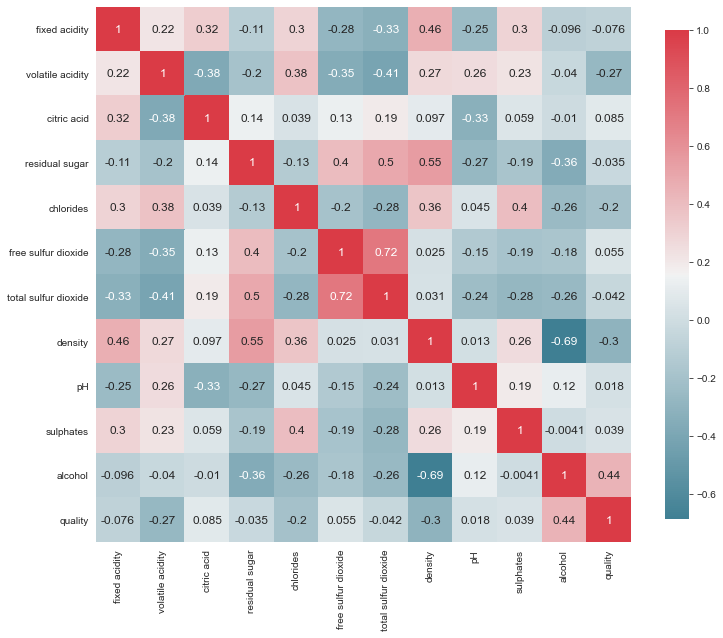

In [24]:
plot_correlation_map(wine)

### 2.4.3 Рассмотрим взаимосвязь между признаками и качеством вина

In [25]:
abs(wine.corr()["quality"]).sort_values(ascending = False)

quality                 1.000000
alcohol                 0.444637
density                 0.304447
volatile acidity        0.266677
chlorides               0.200553
citric acid             0.084926
fixed acidity           0.076174
free sulfur dioxide     0.054924
total sulfur dioxide    0.041598
sulphates               0.039054
residual sugar          0.034654
pH                      0.018403
Name: quality, dtype: float64

Рассмотрим взаимосвязь между цветом вина и оценкой вина

<AxesSubplot:xlabel='type', ylabel='quality'>

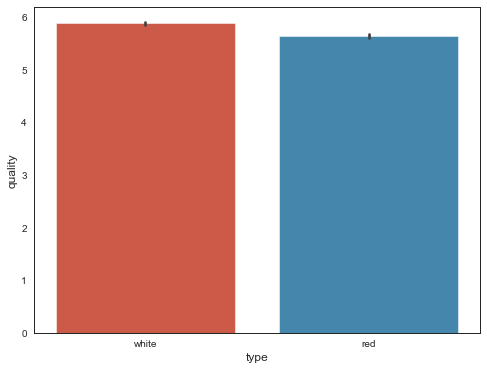

In [26]:
sns.barplot(x = "type", y = "quality", data = wine)

Цвет вина влияет на оценку равным образом.

<AxesSubplot:xlabel='alcohol', ylabel='Density'>

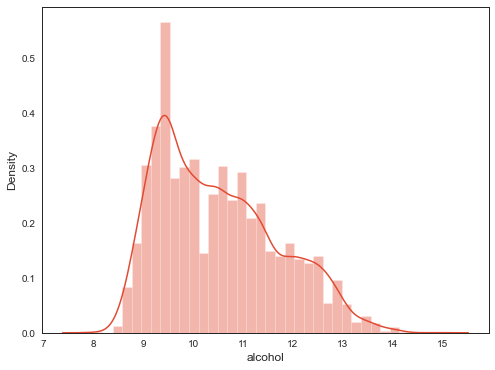

In [27]:
sns.distplot(wine["alcohol"])

<AxesSubplot:xlabel='density', ylabel='Density'>

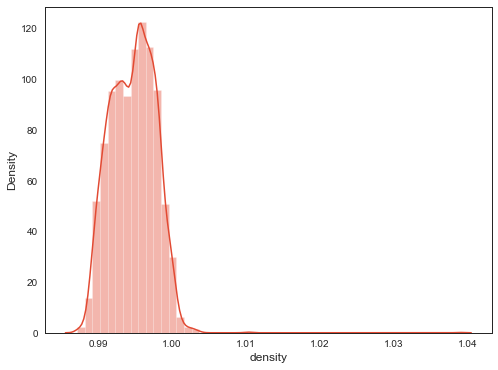

In [28]:
sns.distplot(wine["density"])

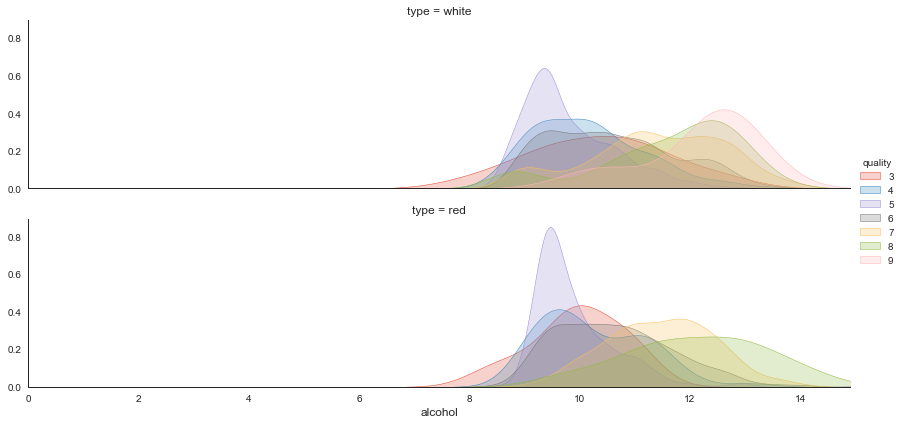

In [29]:
plot_distribution( wine , var = 'alcohol' , target = 'quality', row = 'type' )

Плотность распределения оценки вина от наличия алкоголя. Наилучшм образом отражено среднее качество вина

# 3. Data Preparation

In [30]:
# закодируем таргет в бинарную переменную
bins = (0, 6.5, 9)  # определим бины (корзины)
group_names = ['bad', 'good']  # определим имя классов

# поместим значения качества в соответствующую корзину и положим в новый столбец
wine['quality'] = pd.cut(wine['quality'], bins=bins, labels=group_names)
wine['quality'].unique()

['bad', 'good']
Categories (2, object): ['bad' < 'good']

In [33]:
# Transform data: bad --> 0, good --> 1
wine['quality'] = LabelEncoder().fit_transform(wine['quality'])

In [34]:
# OneHotEncoding type column
one_hot = pd.get_dummies(wine['type'])
wine = wine.drop('type', axis=1)
wine = wine.join(one_hot)

In [35]:
wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,1


In [36]:
# посмотрим на распределение вин по качеству
wine['quality'].value_counts()

0    5192
1    1271
Name: quality, dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

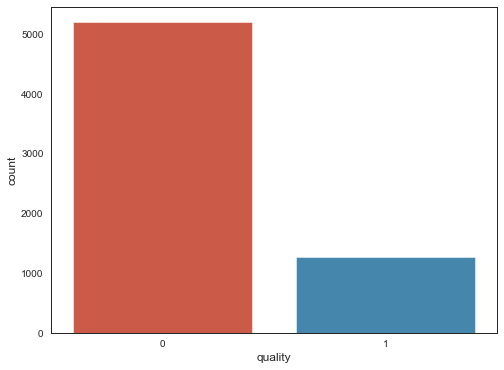

In [37]:
sns.countplot(wine['quality'])

3.1 Сборка финальных датасетов для моделирования

In [38]:
X = wine.drop('quality', axis=1)
y = wine['quality']

### 3.1.1 Variable selection

Выбираем признаки для формирования итогового датасет. У нас доступны признаки:

1 - fixed acidity\ 2 - volatile acidity\ 3 - citric acid\ 4 - residual sugar\ 5 - chlorides\ 6 - free sulfur dioxide\ 7 - total sulfur dioxide\ 8 - density\ 9 - pH\ 10 - sulphates\ 11 - alcohol

### 3.1.2 Создание датасетов

Разделяем данные для обучения и для проверки



In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
print(f'Training data: X: {X_train.shape} y: {y_train.shape}')
print(f'Test data: X: {X_test.shape} y: {y_test.shape}')

Training data: X: (5170, 13) y: (5170,)
Test data: X: (1293, 13) y: (1293,)


### 3.1.3 Важность признаков

Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


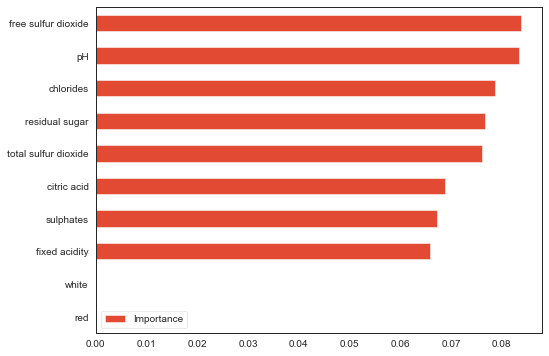

In [40]:
plot_variable_importance(X_train, y_train)

In [48]:
# Применение стандартного масштабирования

feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

## 4. Моделирование

Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели

Хорошей отправной точкой является логистическая регрессия.



In [42]:
model = LogisticRegression()

## 4.2 Обучение модели


In [43]:
model.fit(X_train , y_train)

LogisticRegression()

# 5. Оценка

Теперь мы собираемся оценить модель



## 5.1 Модель


Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [44]:
print(model.score(X_train, y_train), model.score(X_test, y_test))

0.8189555125725339 0.8190255220417634


# 6. Развертывание

Развертывание в данном случае означает публикацию полученного прогноза в таблицу лидеров Kaggle.

In [45]:
wine['predicted'] = model.predict(X)

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white,predicted
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,0,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,0,1,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,1,1


In [46]:
wine.to_csv('wine.csv', index=False)